<a href="https://colab.research.google.com/github/femtonelson/Time-series-power-consumption-forecasting/blob/master/Electrain_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
install.packages('readxl')
install.packages('xts')
install.packages('ggplot2')
install.packages('forecast')
library("readxl")
library("xts")
library("ggplot2")
library("forecast")

In [0]:
data <- read_excel("Elec-train.xlsx", col_names=TRUE)

In [0]:
head(data)

Timestamp,Power (kW),Temp (C°)
<chr>,<dbl>,<dbl>
1/1/2010 1:15,165.1,10.55556
1/1/2010 1:30,151.6,10.55556
1/1/2010 1:45,146.9,10.55556
1/1/2010 2:00,153.7,10.55556
1/1/2010 2:15,153.8,10.55556
1/1/2010 2:30,159.0,10.55556


In [0]:
# Read the input data into xts objects
# January 02nd to February 16th 2020
power <- xts(data[92:4507,2], order.by=as.POSIXct(data$Timestamp[92:4507], format="%m/%d/%Y %H:%M"))
temp <- xts(data[92:4603,3], order.by=as.POSIXct(data$Timestamp[92:4603], format="%m/%d/%Y %H:%M"))

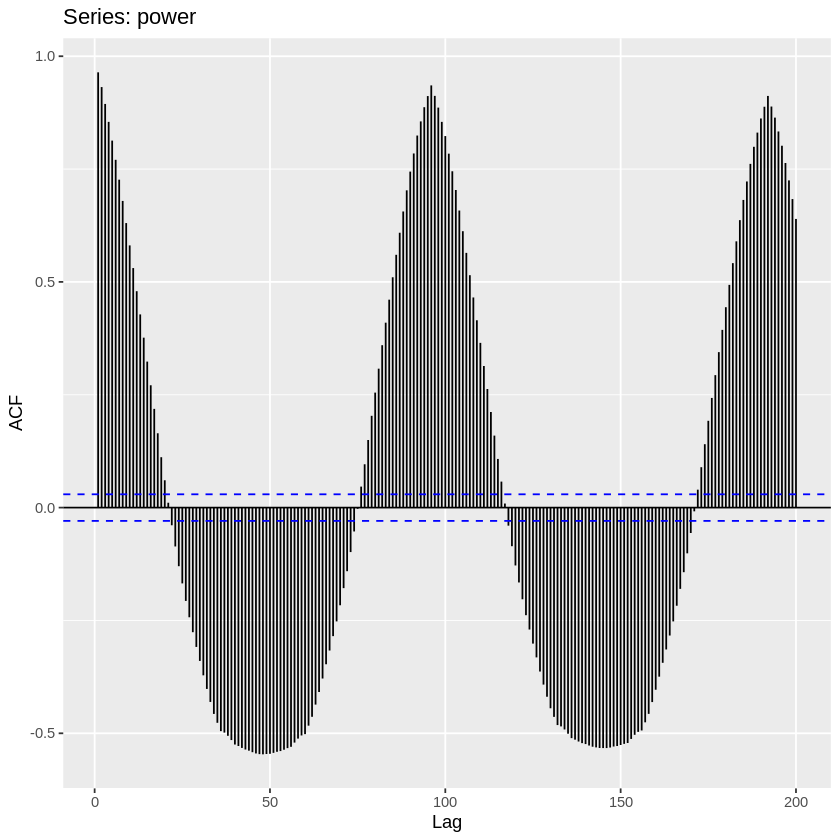

In [0]:
# Identify the frequency of the seasonal pattern observed in the power plot below. 
# It seems to be 96 samples per period (or per day).
ggAcf(power, lag=200)

In [0]:
# The frequency is 96 samples per period, let's create ts objects with this frequency
power = ts(as.numeric(power),freq=96)
temp = ts(as.numeric(temp),freq=96)

# The frequency is 96 and samples are labelled as X.Y
# - X ranges from 1 to 46 (dates from Jan. 02nd to Feb. 16th)
# - 96 values of Y for each value of X, for the samples in a day
frequency(power)
# cycle(power)

[1] 96

In [0]:
# Power train : January 02nd 2010 - February 10th 2010
power_train <- head(power, n=40*96)
# Power Validation : February 11th to 16th 2010
power_val <- tail(power, n=6*96)

# Temperature train : January 02nd 2010 - February 16th 2010
temp_train <- head(temp, n=40*96)
temp_trainval <- head(temp, n=46*96)
# Temperature validation : February 11th to 16th 2010
temp_val <- subset(temp, start=c(40*96+1), end=c(46*96))

# Temperature test : Feb. 17th 2010
temp_test <- tail(temp, n=96)


	Box-Ljung test

data:  diff(power_train, lag = 96)
X-squared = 2288.4, df = 1, p-value < 2.2e-16


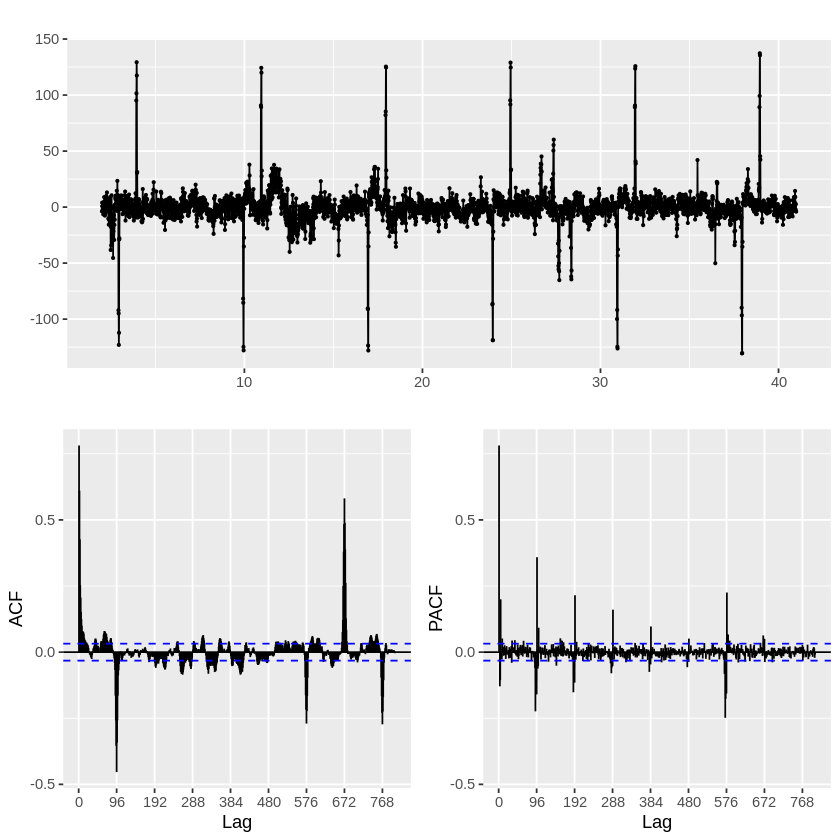

In [0]:
# Perform differencing to remove the seasonal pattern of period 96 and test the result
power_train %>% diff(lag=96) %>% ggtsdisplay(lag=800)
Box.test(diff(power_train, lag=96), type="Ljung-Box")

The resulting series is not white noise as shown by the low p-value. There are significant spikes in the ACF and PACF plots that we will fit a model to capture.
Also, there is no trend.

**1. Forecasting Power without the use of Temperature - SARIMA model**<br>
**Seasonal components**<br>
- No auto regressive components as there is an exponential decay<br>
- Differencing of order 1
- Moving Average component of order 1 (sharp spike in the ACF at lag 96)<br>

**Non-seasonal components**<br>
- Auto Regressive component of order 1 (first spike in PACF after lag=0)
- Differencing of order 0 (no trend).
- Moving average components of order 1 (first spike in ACF after lag=0)

**fit1 model : SARIMA(1,0,1)x(0,1,1)[96]**

Series: power_train 
ARIMA(1,0,1)(0,1,1)[96] 

Coefficients:
         ar1      ma1     sma1
      0.8103  -0.0433  -0.8533
s.e.  0.0116   0.0184   0.0089

sigma^2 estimated as 53.4:  log likelihood=-12820.26
AIC=25648.52   AICc=25648.53   BIC=25673.43

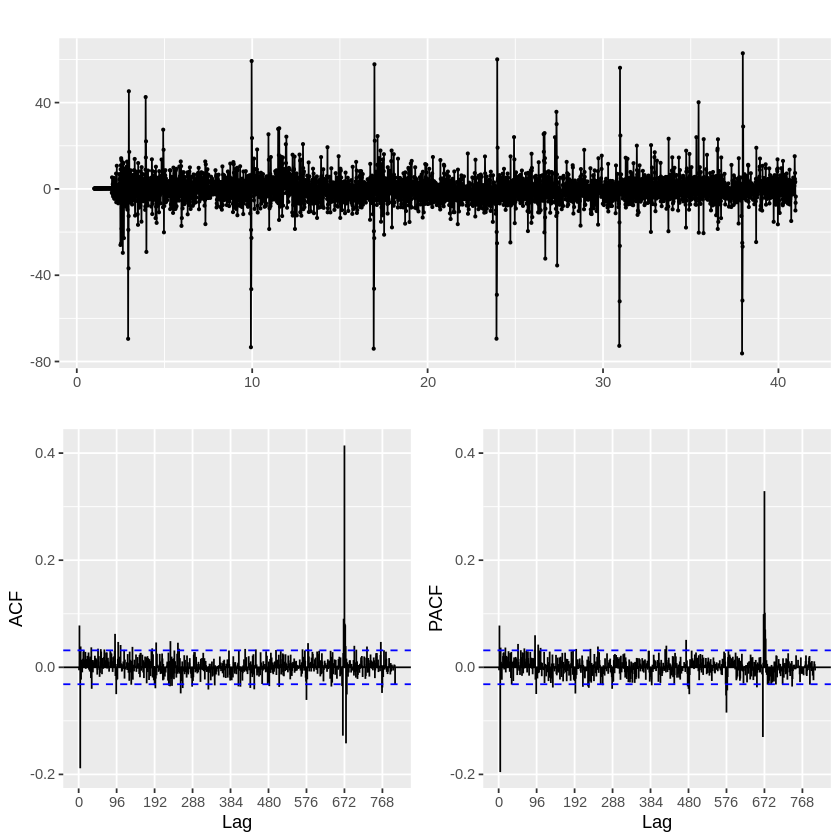


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1)(0,1,1)[96]
Q* = 412.53, df = 189, p-value < 2.2e-16

Model df: 3.   Total lags used: 192



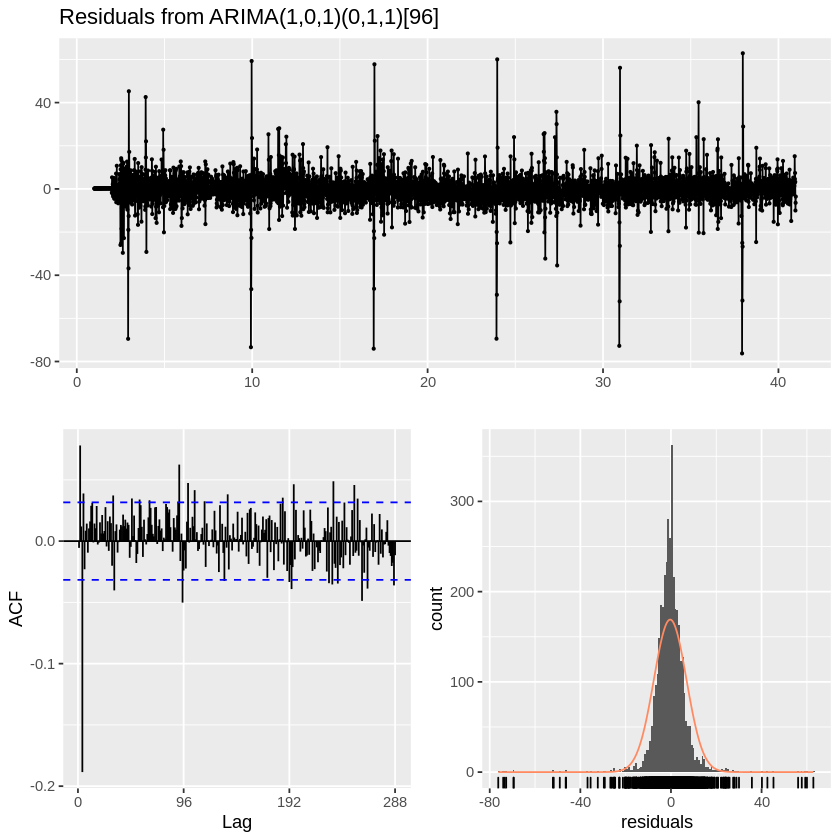

In [0]:
# SARIMA(1,0,1)x(0,1,1) -> Fit the model and check the residuals 
fit1 = Arima(power_train, order=c(1,0,1), seasonal=c(0,1,1))
fit1 %>% residuals() %>% ggtsdisplay(lag=800)
fit1
checkresiduals(fit1)

- There is still some correlation between the residuals (not white noise) as the p-value of the Ljung-Box test is low.
- There are sharp spikes at lags 96 and 672 (seasonal AR and MA components of order 7) which the model cannot capture however due to its maximum supported period of 350.
- Let's try a few more SARIMA models by increasing orders.

**fit2 model : SARIMA(2,0,1)x(0,1,1)[96]**

Series: power_train 
ARIMA(2,0,1)(0,1,1)[96] 

Coefficients:
         ar1     ar2     ma1     sma1
      0.4858  0.2653  0.2658  -0.8529
s.e.  0.0973  0.0773  0.0976   0.0088

sigma^2 estimated as 53.32:  log likelihood=-12816.96
AIC=25643.91   AICc=25643.93   BIC=25675.05

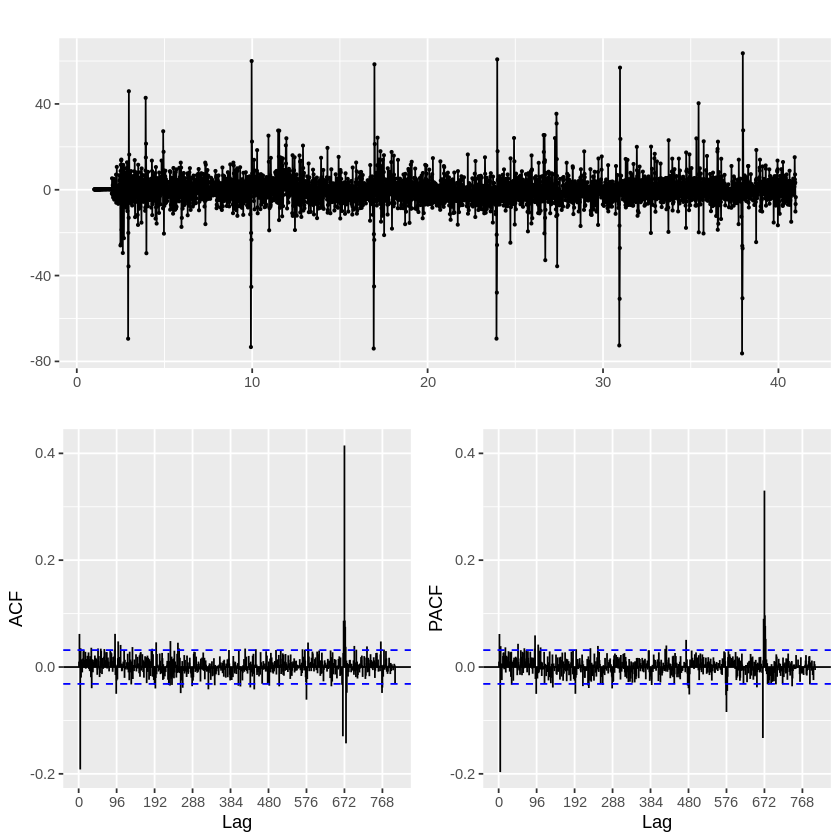


	Ljung-Box test

data:  Residuals from ARIMA(2,0,1)(0,1,1)[96]
Q* = 404.9, df = 188, p-value < 2.2e-16

Model df: 4.   Total lags used: 192



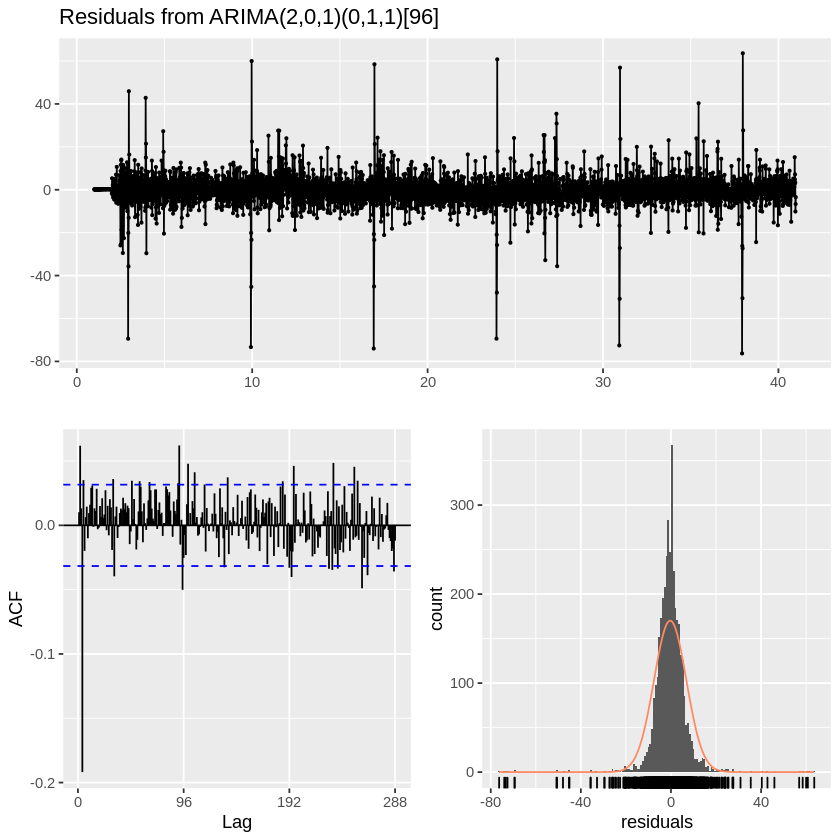

In [0]:
# SARIMA(2,0,1)x(0,1,1) -> Fit the model and check the residuals
fit2 = Arima(power_train, order=c(2,0,1), seasonal=c(0,1,1))
fit2 %>% residuals() %>% ggtsdisplay(lag=800)
fit2
checkresiduals(fit2)

fit1 : AIC=25648.52   AICc=25648.53   BIC=25673.43 <br>
fit2 : AIC=25643.91   AICc=25643.93   BIC=25675.05 <br>
- We have successfully reduced the AIC score to 25643.91 (fit2 model) but the p-value is still low. Let's try another model by increasing orders.

**fit3 model : SARIMA(3,0,1)x(0,1,1)[96]**

Series: power_train 
ARIMA(3,0,1)(0,1,1)[96] 

Coefficients:
         ar1     ar2      ar3      ma1     sma1
      0.9142  0.0028  -0.1040  -0.1511  -0.8464
s.e.  0.0772  0.0623   0.0165   0.0762   0.0090

sigma^2 estimated as 52.95:  log likelihood=-12801.51
AIC=25615.02   AICc=25615.04   BIC=25652.39

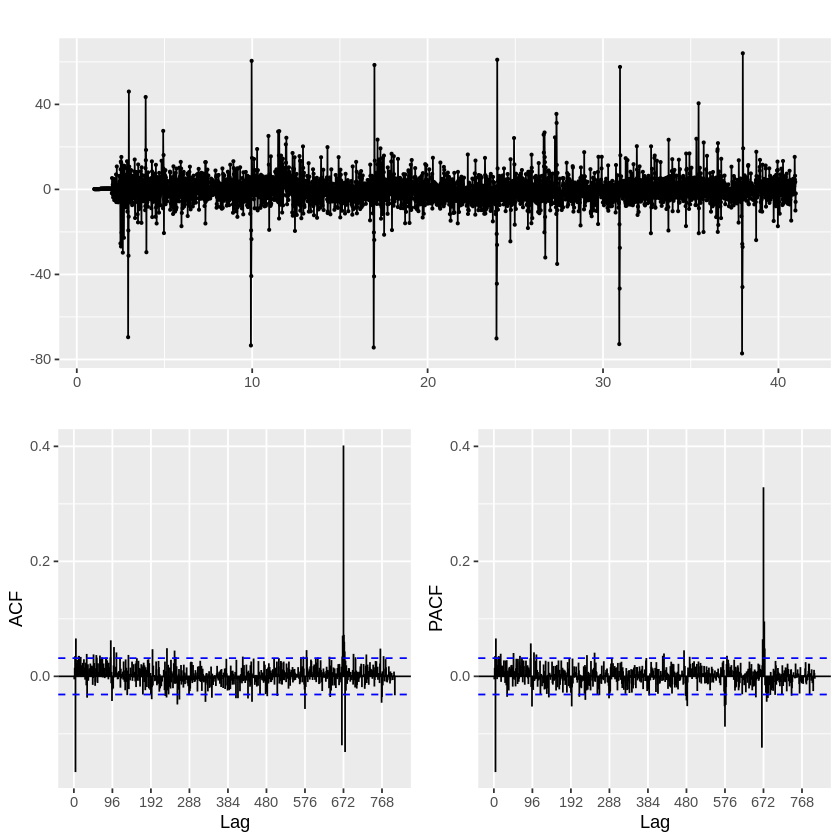


	Ljung-Box test

data:  Residuals from ARIMA(3,0,1)(0,1,1)[96]
Q* = 398.72, df = 187, p-value < 2.2e-16

Model df: 5.   Total lags used: 192



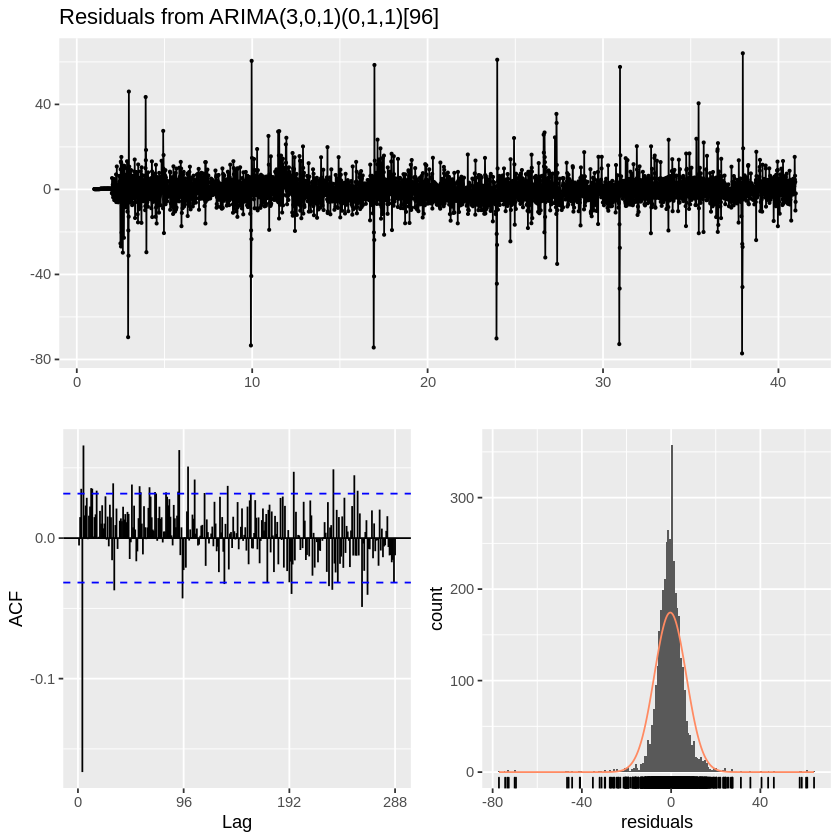

In [0]:
# SARIMA(3,0,1)x(0,1,1) -> Fit the model and check the residuals
fit3 = Arima(power_train, order=c(3,0,1), seasonal=c(0,1,1))
fit3 %>% residuals() %>% ggtsdisplay(lag=800)
fit3
checkresiduals(fit3)

fit1 : AIC=25648.52   AICc=25648.53   BIC=25673.43 <br>
fit2 : AIC=25643.91   AICc=25643.93   BIC=25675.05 <br>
fit3 : AIC=25615.02   AICc=25615.04   BIC=25652.39 <br>
- We have successfully reduced the AIC score with the model fit3 but the p-value is still low (white noise hypothesis rejected).
- Let's increase the seasonal moving average order to 2 in the next model.

**fit4 model : SARIMA(3,0,1)x(0,1,2)[96]**

Series: power_train 
ARIMA(3,0,1)(0,1,2)[96] 

Coefficients:
        ar1     ar2      ar3      ma1     sma1    sma2
      0.909  0.0082  -0.1031  -0.1472  -0.8913  0.0513
s.e.  0.078  0.0627   0.0166   0.0770   0.0178  0.0174

sigma^2 estimated as 52.82:  log likelihood=-12797.16
AIC=25608.32   AICc=25608.35   BIC=25651.91

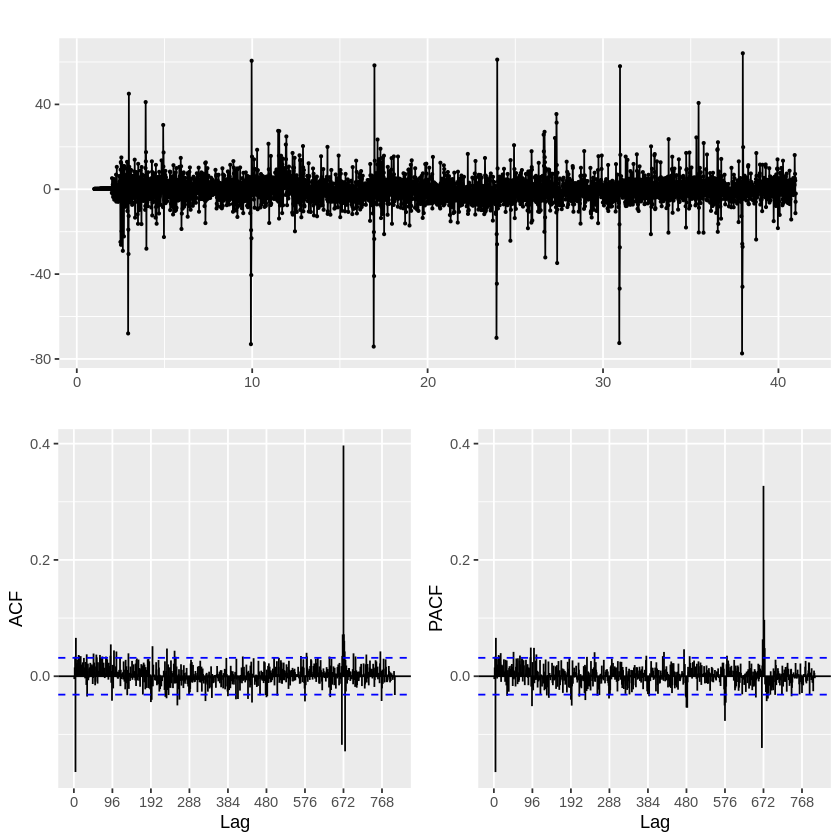


	Ljung-Box test

data:  Residuals from ARIMA(3,0,1)(0,1,2)[96]
Q* = 399.95, df = 186, p-value < 2.2e-16

Model df: 6.   Total lags used: 192



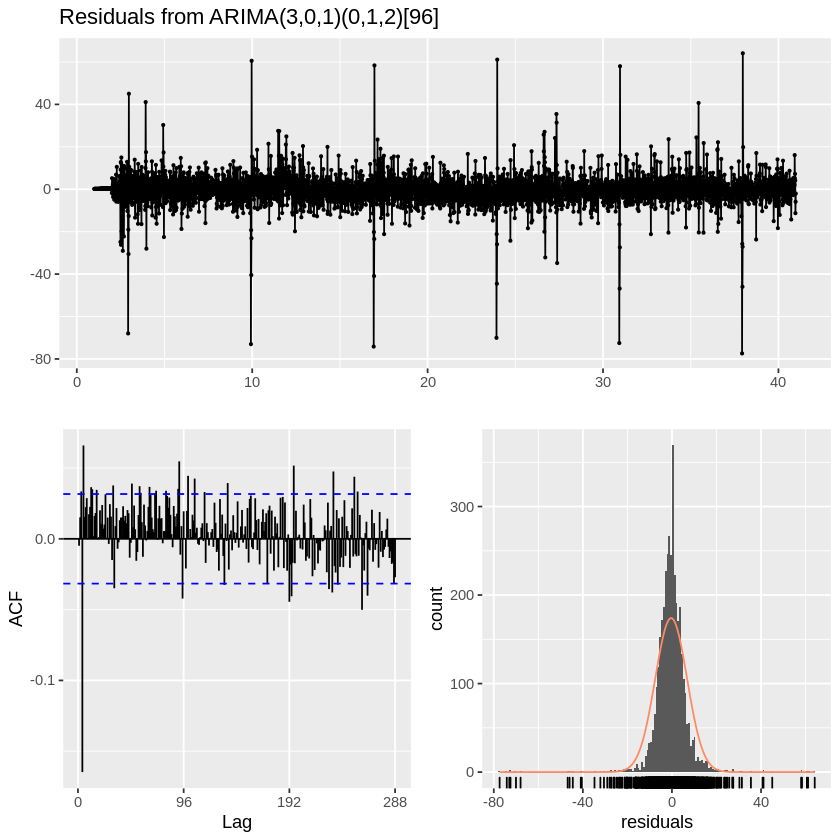

In [0]:
# SARIMA(3,0,1)x(0,1,2) -> Fit the model and check the residuals
fit4 = Arima(power_train, order=c(3,0,1), seasonal=c(0,1,2))
fit4 %>% residuals() %>% ggtsdisplay(lag=800)
fit4
checkresiduals(fit4)

fit1 : AIC=25648.52   AICc=25648.53   BIC=25673.43 <br>
fit2 : AIC=25643.91   AICc=25643.93   BIC=25675.05 <br>
fit3 : AIC=25615.02   AICc=25615.04   BIC=25652.39 <br>
fit4 : AIC=25608.32   AICc=25608.35   BIC=25651.91 <br>
- We have successfully reduced the AIC score with the model fit4 however the p-value is still low (white noise hypothesis rejected). The best of the above 4 models will be determined using validation data.

**Model Validation on power_val data**<br>
Let's evaluate the above SARIMA models on unseen data and choose the best model.

In [0]:
# Predict the power values (from Feb. 11th to 16th: 6 days*24 hours*4=576) with the models
power_pred1 = forecast(fit1,h=576)
power_pred2 = forecast(fit2,h=576)
power_pred3 = forecast(fit3,h=576)
power_pred4 = forecast(fit4,h=576)

# Evaluate Root Mean Square Errors
RMSE1 = sqrt(mean((power_pred1$mean-power_val)^2))
RMSE2 = sqrt(mean((power_pred2$mean-power_val)^2))
RMSE3 = sqrt(mean((power_pred3$mean-power_val)^2))
RMSE4 = sqrt(mean((power_pred4$mean-power_val)^2))

# Print
print(RMSE1)
print(RMSE2)
print(RMSE3)
print(RMSE4)

[1] 15.89451
[1] 15.89539
[1] 15.91101
[1] 15.95326


**The best model is fit1 : SARIMA(1,0,1)x(0,1,1)[96], with RMSE=15.89451.**

**Predict power consumption for Feb. 17th 2010**

In [0]:
# Display options
options(repr.plot.width=12, repr.plot.height=8)

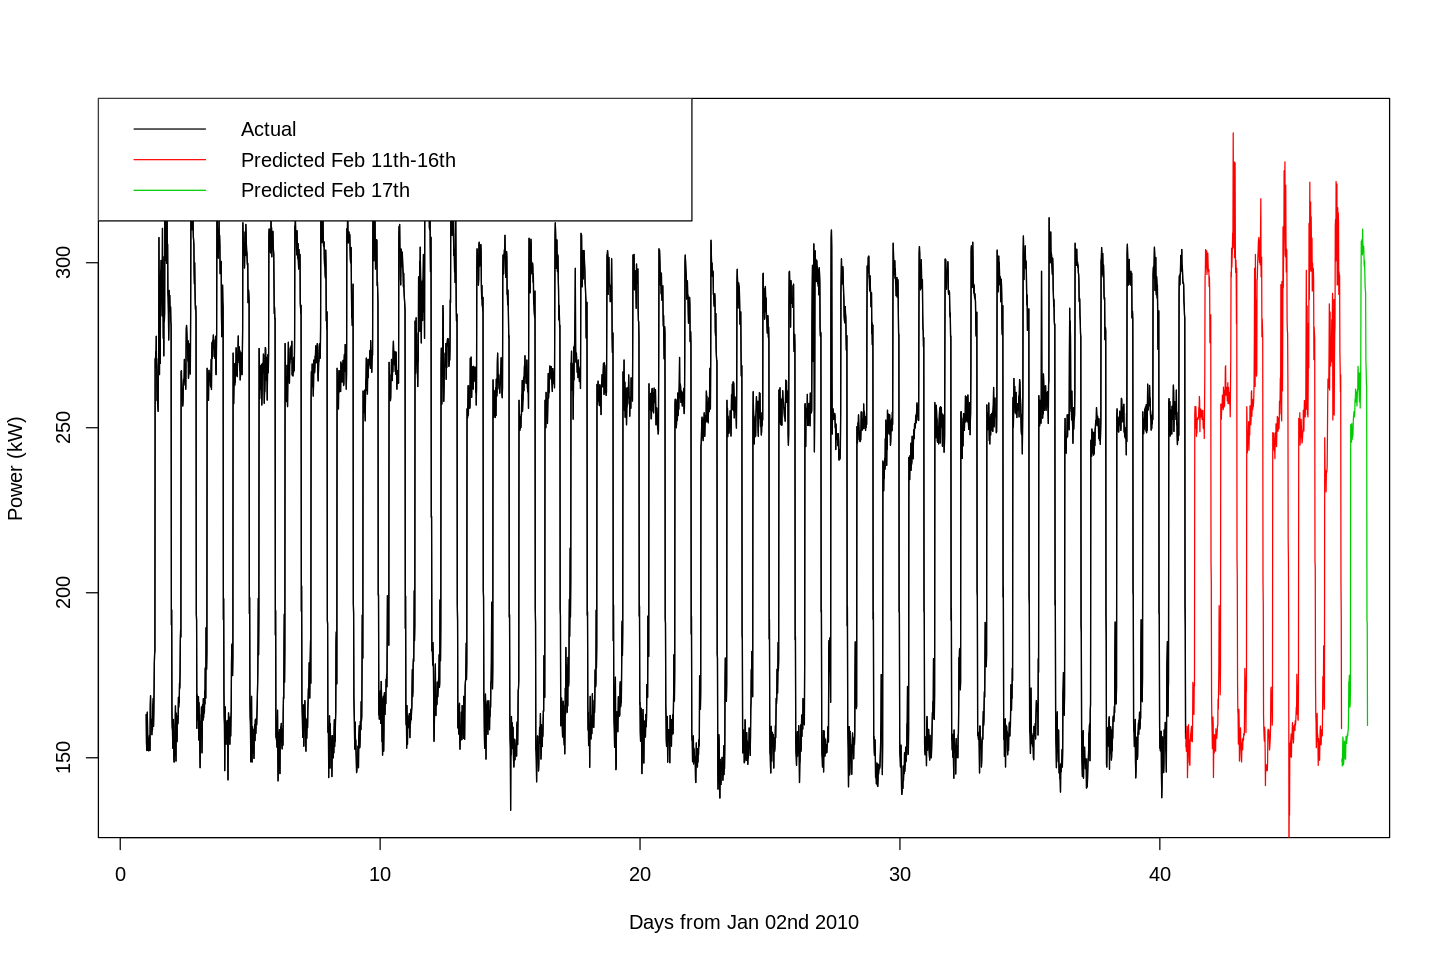

In [0]:
# Fit the final model with all power data (Jan 02nd - Feb 16th 2010)
fitsarima_no_temp <- Arima(power, order=c(1,0,1), seasonal=c(0,1,1))

# Forecast the power consumption for Feb. 17th (96 values)
power_pred = forecast(fitsarima_no_temp, h=96)

# Save prediction to csv
write.csv(power_pred$mean, file ="power_pred_no_temp.csv", row.names=FALSE)

# Plot the actual and predicted power [Feb. 11th - February 17th]
plot(power_train, xlim=c(1,47), ylab = "Power (kW)", xlab= "Days from Jan 02nd 2010")
lines(power_train, lty=1)
lines(tail(fitted(fitsarima_no_temp), 6*96), col=2)  # Predicted Feb11th-16th
lines(power_pred$mean, col=3)                        # Predicted Feb17th
legend('topleft', col=1:3, lty=1, legend=c('Actual',"Predicted Feb 11th-16th", "Predicted Feb 17th"))

**2. Forecasting Power with the use of Temperature** <br>
Use a dynamic regression model to forecast power using temperature and simultaneously capture the residuals with the above model to improve the overall power forecasting accuracy.

Series: power_train 
Regression with ARIMA(1,0,1)(0,1,1)[96] errors 

Coefficients:
         ar1      ma1     sma1    xreg
      0.8062  -0.0416  -0.8525  0.4885
s.e.  0.0118   0.0184   0.0088  0.2194

sigma^2 estimated as 53.35:  log likelihood=-12817.84
AIC=25645.68   AICc=25645.7   BIC=25676.82

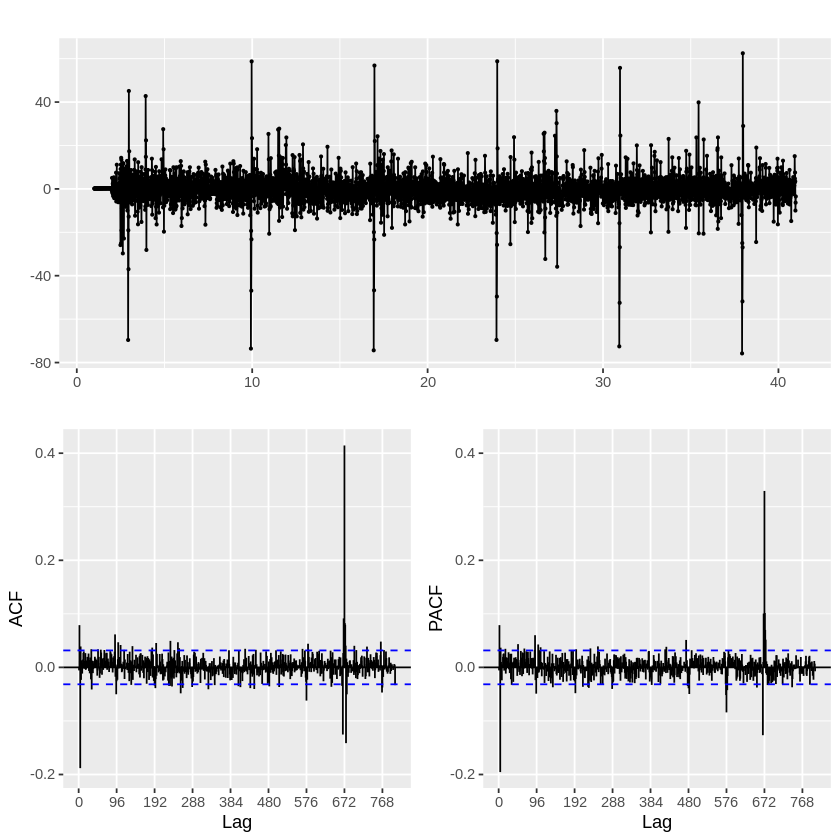


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,0,1)(0,1,1)[96] errors
Q* = 406.07, df = 188, p-value < 2.2e-16

Model df: 4.   Total lags used: 192



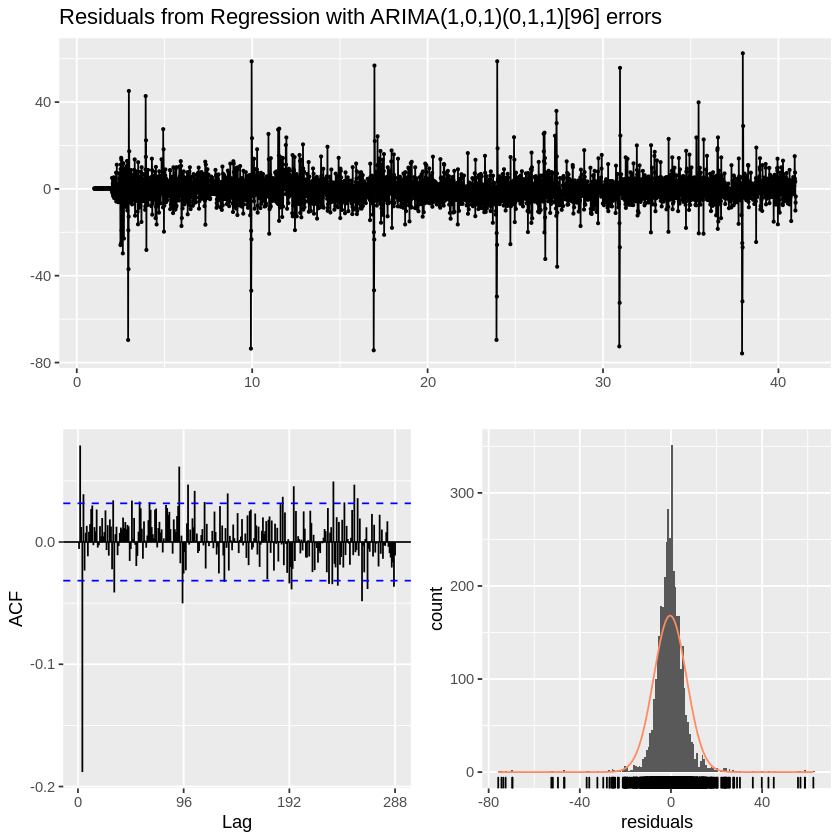

In [0]:
fitsarima_temp = Arima(power_train, order=c(1,0,1), seasonal=c(0,1,1), xreg=temp_train)
fitsarima_temp %>% residuals() %>% ggtsdisplay(lag=800)
fitsarima_temp
checkresiduals(fitsarima_temp)

In [0]:
# Model validation
power_pred_with_temp = forecast(fitsarima_temp, h=576, xreg = temp_val)

# Root Mean Square Error
print(sqrt(mean((power_pred_with_temp$mean-power_val)^2)))

[1] 15.49976


- fitsarima_no_temp (without temperature) : SARIMA(1,0,1)x(0,1,1)[96] model without temperature, RMSE=15.89451.
- fitsarima_temp (with temperature) : Regression with SARIMA(1,0,1)(0,1,1)[96] errors, RMSE = 15.49976

**The regression model with SARIMA errors is more accurate, as it gives a lower RMSE.**

**Predict power consumption for Feb. 17th 2010**

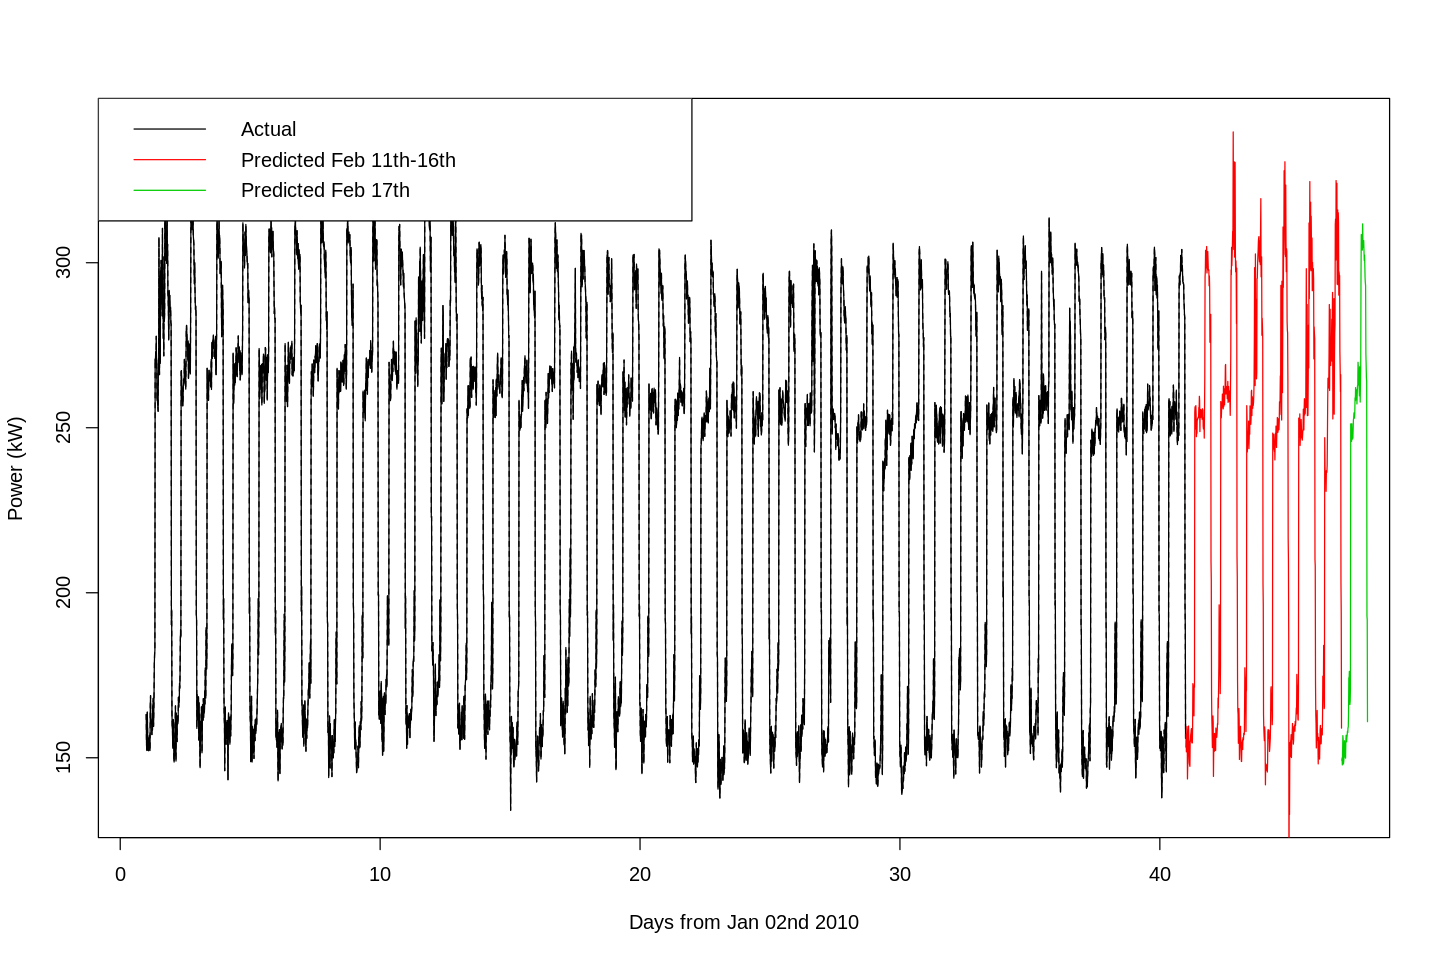

In [0]:
# Fit the final model with all power & temp data (Jan 02nd - Feb 16th 2010)
fitsarima_temp <- Arima(power, order=c(1,0,1), seasonal=c(0,1,1), xreg=temp_trainval)

# Forecast the power consumption for Feb. 17th (96 values)
power_pred_temp_test = forecast(fitsarima_temp, h=96, xreg=temp_test)

# Save prediction to csv
write.csv(power_pred_temp_test$mean, file ="power_pred_temp.csv", row.names=FALSE)

# Plot the actual and predicted power [Feb. 11th - February 17th]
plot(power_train, xlim=c(1,47), ylab = "Power (kW)", xlab= "Days from Jan 02nd 2010")
lines(power_train, lty=1)
lines(tail(fitted(fitsarima_temp), 6*96), col=2)     # Predicted Feb11th-16th
lines(power_pred_temp_test$mean, col=3)              # Predicted Feb17th
legend('topleft', col=1:3, lty=1, legend=c('Actual',"Predicted Feb 11th-16th", "Predicted Feb 17th"))

Conclusion : 
The models obtained give visually acceptable results on validation data with root mean square errors of 15.89kW and 15.49kW. However the residuals of our models still have correlations (low p-value of Box-test) and we could not model the seasonal auto regressive and moving average components of order 7 in the power series. Trying a neural network model is another option to consider.